In [2]:
#!/usr/bin/env python
# coding: utf-8
%pip install keras

Note: you may need to restart the kernel to use updated packages.


In[1]:

The following is based on a tutorial by Dr. Jason Brownlee at<br>
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

Imports

In[2]:

In [3]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import pandas as pd
import time

2024-08-13 11:07:22.408752: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-13 11:07:22.425959: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-13 11:07:22.573017: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-13 11:07:22.717251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 11:07:22.835554: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

In[3]:

convert series to supervised learning

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Initial Preprocessing

In[4]:

In [ ]:
from pandas import read_csv
#data = pd.read_csv('data.csv')
#data = data.drop('No', axis=1, inplace=False)

In[5]:

ata = data.drop(['year','month','day','hour'], axis=1, inplace=False)

In[6]:

ata.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']

In[7]:

mark all NA values with 0<br>
ata['pollution'].fillna(0, inplace=True)<br>
drop the first 24 hours<br>
ata = data[24:]<br>
summarize first 5 rows<br>
rint(data.head(5))<br>
save to file<br>
ata.to_csv('pollution.csv')

## Baseline LSTM + room to change network architecture

In[8]:

load dataset

In [5]:
dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features (after I reframe into a supervised learning problem)
# frame as supervised learning -
####### Can change t_input timesteps here ##########  ### I changed it to time lag = 4
reframed = series_to_supervised(values, 4, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-7,-6,-5,-4,-3,-2,-1]], axis=1, inplace=True)
print(reframed.head())

   var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
4      129.0      -16.0       -4.0     1020.0        2.0       1.79   
5      148.0      -15.0       -4.0     1020.0        2.0       2.68   
6      159.0      -11.0       -5.0     1021.0        2.0       3.57   
7      181.0       -7.0       -5.0     1022.0        2.0       5.36   
8      138.0       -7.0       -5.0     1022.0        2.0       6.25   

   var7(t-4)  var8(t-4)  var1(t-3)  var2(t-3)  ...  var8(t-2)  var1(t-1)  \
4        0.0        0.0      148.0      -15.0  ...        0.0      181.0   
5        0.0        0.0      159.0      -11.0  ...        0.0      138.0   
6        0.0        0.0      181.0       -7.0  ...        0.0      109.0   
7        1.0        0.0      138.0       -7.0  ...        0.0      105.0   
8        2.0        0.0      109.0       -7.0  ...        0.0      124.0   

   var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  var7(t-1)  \
4       -7.0       -5.0     1022.0        2.0

split into train and test sets

In [6]:
values = reframed.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(values[:,:-1])
scaled_label = scaler.fit_transform(values[:,-1].reshape(-1,1))
values = np.column_stack((scaled_features, scaled_label))

In [7]:
n_train_hours = 365 * 24 * 4
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
# features take all values except the var1
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(50, activation='tanh'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

(35040, 1, 32) (35040,) (8756, 1, 32) (8756,)


/home/sasquach/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In[9]:

In [8]:
print(reframed.head())

   var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
4      129.0      -16.0       -4.0     1020.0        2.0       1.79   
5      148.0      -15.0       -4.0     1020.0        2.0       2.68   
6      159.0      -11.0       -5.0     1021.0        2.0       3.57   
7      181.0       -7.0       -5.0     1022.0        2.0       5.36   
8      138.0       -7.0       -5.0     1022.0        2.0       6.25   

   var7(t-4)  var8(t-4)  var1(t-3)  var2(t-3)  ...  var8(t-2)  var1(t-1)  \
4        0.0        0.0      148.0      -15.0  ...        0.0      181.0   
5        0.0        0.0      159.0      -11.0  ...        0.0      138.0   
6        0.0        0.0      181.0       -7.0  ...        0.0      109.0   
7        1.0        0.0      138.0       -7.0  ...        0.0      105.0   
8        2.0        0.0      109.0       -7.0  ...        0.0      124.0   

   var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  var7(t-1)  \
4       -7.0       -5.0     1022.0        2.0

### Train and Test Neural Network

In[10]:

In [9]:
start = time.time()

fit network<br>
#################### Can change Epochs, Batch size here #######################

Epoch 1/25
487/487 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0376 - val_loss: 0.0181
Epoch 2/25
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0192 - val_loss: 0.0232
Epoch 3/25
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0169 - val_loss: 0.0145
Epoch 4/25
487/487 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0162 - val_loss: 0.0169
Epoch 5/25
487/487 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0157 - val_loss: 0.0196
Epoch 6/25
487/487 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0153 - val_loss: 0.0177
Epoch 7/25
487/487 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0156 - val_loss: 0.0172
Epoch 8/25
487/487 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0153 - val_loss: 0.0173
Epoch 9/25
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0151 - val_loss: 0.0196
Epoch 10/25
487/487 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0150 - val_loss: 0.0181
Epoch 11/25
487/487 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0148 - val_loss: 0.0180
Epoch 12/25
487/487 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

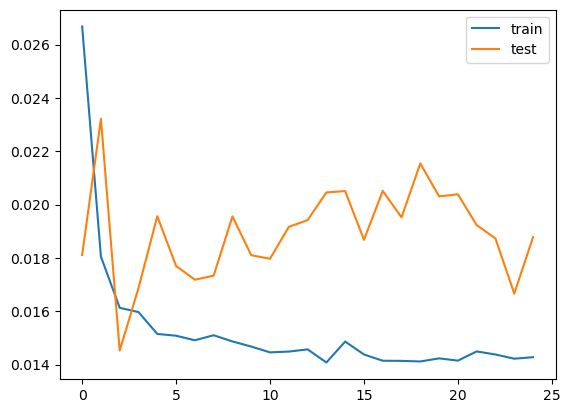

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
This took 86.1102602481842 seconds.
Test RMSE: 30.055


In [10]:
history = model.fit(train_X, train_y, epochs=25, batch_size=72, validation_data=(test_X, test_y), 
                    verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
end = time.time()
print('This took {} seconds.'.format(end - start))
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE of 25.654 on best run

### Plot Predicted vs. Actual and Calculate Errors

In[15]:

In [11]:
from matplotlib import pyplot as plt

In[16]:

In [12]:
def plot_predicted(predicted_data, true_data):
    fig, ax = plt.subplots(figsize=(17,8))
    ax.set_title('Prediction vs. Actual after 100 epochs of training')
    ax.plot(true_data, label='True Data', color='green', linewidth='3')
    ax.plot(predicted_data, label='Prediction', color='red', linewidth='2')
    plt.legend()
    plt.show()

In[17]:

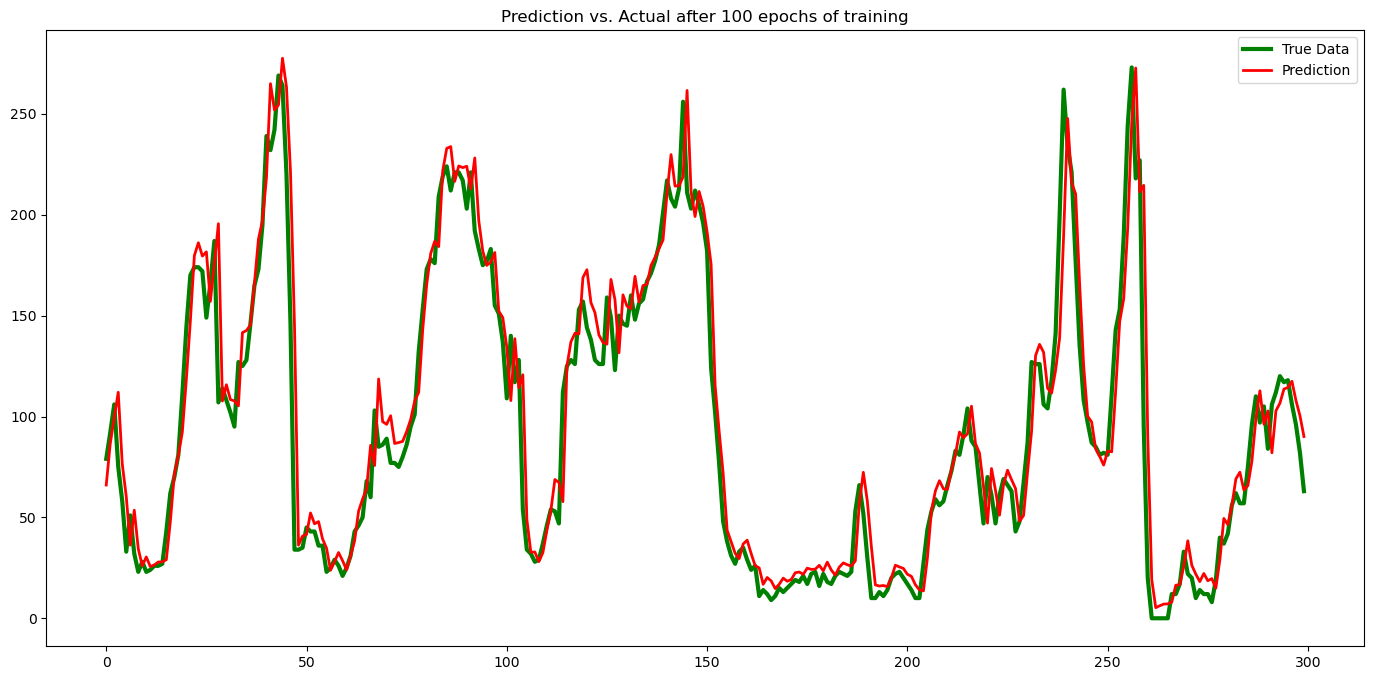

In [13]:
plot_predicted(inv_yhat[:300,], inv_y[:300,])

In[18]:

In [14]:
print('Root Mean Squared Error: {:.4f}'.format(rmse))

Root Mean Squared Error: 30.0546


alculate R^2 (regression score function)<br>
rint('Variance score: %.2f' % r2_score(y, data_pred))

In [15]:
print('Variance score: {:2f}'.format(r2_score(inv_y, inv_yhat)))

Variance score: 0.896862


In[ ]: